In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import string
import nltk
nltk.download('averaged_perceptron_tagger');

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss

from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams["figure.figsize"] = (12, 8)
pd.set_option('display.max_columns', None)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\MIKE\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [4]:
#Plot the LGBM Features Importances
def plotImp(model, X , num = 40, fig_size = (60, 40)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()

# Read and Preparing The Data


In [5]:
train_df = pd.read_csv("Train.csv")
test_df = pd.read_csv("Test.csv")
extra_df = pd.read_csv("extra_data.csv")

## Sort The Samples Based on Purchase Date

In [6]:
train_df = train_df.sort_values('PURCHASED_AT').reset_index(drop=True) 
test_df = test_df.sort_values('PURCHASED_AT').reset_index(drop=True)
extra_df = extra_df.sort_values('PURCHASED_AT').reset_index(drop=True)

## Set Purchase Date as Index

In [7]:
for dataset in (train_df,test_df,extra_df):
    dataset['PURCHASED_AT'] = pd.to_datetime(dataset['PURCHASED_AT'])
    dataset.set_index('PURCHASED_AT', inplace=True)

## Some Modifications to The Data

In [8]:
for dataset in (train_df,test_df,extra_df):
    for i in dataset.index:
        if('SAFARICOM' in dataset['MERCHANT_NAME'][i]):
            dataset['MERCHANT_NAME'][i] = 'SAFARICOM'
        if('QUICK MART' in dataset['MERCHANT_NAME'][i]):
            dataset['MERCHANT_NAME'][i] = 'QUICK MART'
        if('JERUSA' in dataset['MERCHANT_NAME'][i]):
            dataset['MERCHANT_NAME'][i] = 'JERUSA'
        if('CARREFOUR' in dataset['MERCHANT_NAME'][i]):
            dataset['MERCHANT_NAME'][i] = 'CARREFOUR'

## Store Target Labels For Later Usage

In [9]:
Target_Values = train_df['MERCHANT_CATEGORIZED_AS'].value_counts().keys().sort_values()

## Drop Transactions IDs

In [10]:
ID = test_df['Transaction_ID']
train_df.drop('Transaction_ID',inplace=True,axis=1)
test_df.drop('Transaction_ID',inplace=True,axis=1)
extra_df.drop('Transaction_ID',inplace=True,axis=1)

# Exploratory data analysis

## Features:

* MERCHANT_CATEGORIZED_AT:	The time the merchant was categorized by the customer
* MERCHANT_NAME:	The name of the merchant
* MERCHANT_CATEGORIZED_AS:	The category the merchant was assigned by the customer
* PURCHASE_VALUE:	The value of the purchase made by the customer
* PURCHASED_AT:	The time the purchase was made
* IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY:	If true indicates that the merchant is not a registered business name
* USER_EMAIL:	The email of the customer
* USER_AGE:	The age of the customer
* USER_GENDER:	The gender of the customer
* USER_HOUSEHOLD:	The number of family members
* USER_INCOME:	The monthly income of the customer


## Description

In [11]:
train_df.shape

(373, 10)

In [12]:
test_df.shape

(558, 9)

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 373 entries, 2018-12-05 09:36:00+00:00 to 2022-06-06 14:55:00+00:00
Data columns (total 10 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   MERCHANT_CATEGORIZED_AT                373 non-null    object 
 1   MERCHANT_NAME                          373 non-null    object 
 2   MERCHANT_CATEGORIZED_AS                373 non-null    object 
 3   PURCHASE_VALUE                         373 non-null    int64  
 4   IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY  373 non-null    bool   
 5   USER_AGE                               61 non-null     float64
 6   USER_GENDER                            367 non-null    object 
 7   USER_HOUSEHOLD                         373 non-null    int64  
 8   USER_INCOME                            373 non-null    int64  
 9   USER_ID                                373 non-null    object 
dtypes: bool(1), float64(1), i

In [14]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 558 entries, 2018-12-05 09:36:00+00:00 to 2022-06-06 16:32:00+00:00
Data columns (total 9 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   MERCHANT_CATEGORIZED_AT                558 non-null    object 
 1   MERCHANT_NAME                          558 non-null    object 
 2   PURCHASE_VALUE                         558 non-null    int64  
 3   IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY  558 non-null    bool   
 4   USER_AGE                               85 non-null     float64
 5   USER_GENDER                            553 non-null    object 
 6   USER_HOUSEHOLD                         558 non-null    int64  
 7   USER_INCOME                            558 non-null    int64  
 8   USER_ID                                558 non-null    object 
dtypes: bool(1), float64(1), int64(3), object(4)
memory usage: 55.9+ KB


In [15]:
train_df.head()

,MERCHANT_CATEGORIZED_AT,MERCHANT_NAME,MERCHANT_CATEGORIZED_AS,PURCHASE_VALUE,IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY,USER_AGE,USER_GENDER,USER_HOUSEHOLD,USER_INCOME,USER_ID
PURCHASED_AT,,,,,,,,,,
2018-12-05 09:36:00+00:00,2022-03-16 13:05:51.851102+00,TUSKYS -CHAP CHAP THIGIRI,Going out,3486,False,NaN,Female,1,10000,ID_40L9OTIM
2019-03-11 05:38:00+00:00,2022-03-16 13:08:19.703288+00,JIMMIE WAIRIMU,Bills & Fees,40000,True,NaN,Female,1,10000,ID_40L9OTIM
2019-03-11 05:38:00+00:00,2022-03-16 13:05:51.851102+00,JIMMIE WAIRIMU,Bills & Fees,40000,True,NaN,Female,1,10000,ID_40L9OTIM
2019-03-25 09:46:00+00:00,2022-06-01 10:23:56.42678+00,MELISA ANYONJE MALALA,Family & Friends,230,True,NaN,Female,3,85000,ID_J8O7LHZ2
2019-05-20 15:27:00+00:00,2022-05-31 13:27:24.704992+00,PETER NJOORA KENDA,Miscellaneous,300,True,NaN,Female,3,85000,ID_J8O7LHZ2


In [16]:
test_df.head()

,MERCHANT_CATEGORIZED_AT,MERCHANT_NAME,PURCHASE_VALUE,IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY,USER_AGE,USER_GENDER,USER_HOUSEHOLD,USER_INCOME,USER_ID
PURCHASED_AT,,,,,,,,,
2018-12-05 09:36:00+00:00,2022-03-16 13:08:19.703288+00,TUSKYS -CHAP CHAP THIGIRI,3486,False,NaN,Female,1,10000,ID_40L9OTIM
2019-01-07 07:35:00+00:00,2022-05-31 13:27:24.704992+00,TELKOM KENYA LIMITED,100,True,NaN,Female,3,85000,ID_J8O7LHZ2
2019-04-19 08:53:00+00:00,2022-06-01 10:23:56.42678+00,TELKOM KENYA LIMITED,100,True,NaN,Female,1,85000,ID_1I8XYBWK
2019-05-31 13:49:00+00:00,2022-03-16 13:08:19.703288+00,PETER NJOORA KENDA,300,True,NaN,Female,1,85000,ID_1I8XYBWK
2019-05-31 13:49:00+00:00,2022-03-16 13:05:51.851102+00,PETER NJOORA KENDA,300,True,NaN,Female,1,85000,ID_1I8XYBWK


In [17]:
train_df.describe()

,PURCHASE_VALUE,USER_AGE,USER_HOUSEHOLD,USER_INCOME
count,373.000000,61.000000,373.000000,373.000000
mean,4506.522788,25.803279,2.831099,146235.924933
std,15722.261797,1.423841,1.600033,166521.780346
min,10.000000,25.000000,1.000000,8000.000000
25%,150.000000,25.000000,1.000000,23000.000000
50%,690.000000,25.000000,3.000000,90000.000000
75%,2000.000000,27.000000,4.000000,200000.000000
max,150000.000000,32.000000,7.000000,1000000.000000


In [18]:
test_df.describe()

,PURCHASE_VALUE,USER_AGE,USER_HOUSEHOLD,USER_INCOME
count,558.000000,85.000000,558.000000,558.000000
mean,4224.754480,26.105882,2.856631,138435.483871
std,14434.636472,1.976189,1.677034,158829.296357
min,1.000000,25.000000,1.000000,8000.000000
25%,110.000000,25.000000,1.000000,23000.000000
50%,500.000000,25.000000,3.000000,85000.000000
75%,2100.000000,27.000000,4.000000,200000.000000
max,150000.000000,32.000000,9.000000,1000000.000000


In [19]:
#The cardinality of each catgorical feature (Training)
cat_cols = train_df.columns
for col in cat_cols:
    print(col, train_df[col].nunique())

MERCHANT_CATEGORIZED_AT 58
MERCHANT_NAME 211
MERCHANT_CATEGORIZED_AS 13
PURCHASE_VALUE 150
IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY 2
USER_AGE 4
USER_GENDER 2
USER_HOUSEHOLD 7
USER_INCOME 15
USER_ID 25


In [20]:
#The cardinality of each catgorical feature (Testing)
cat_cols = test_df.columns
for col in cat_cols:
    print(col, test_df[col].nunique())

MERCHANT_CATEGORIZED_AT 57
MERCHANT_NAME 303
PURCHASE_VALUE 213
IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY 2
USER_AGE 5
USER_GENDER 2
USER_HOUSEHOLD 9
USER_INCOME 17
USER_ID 30


## Plots


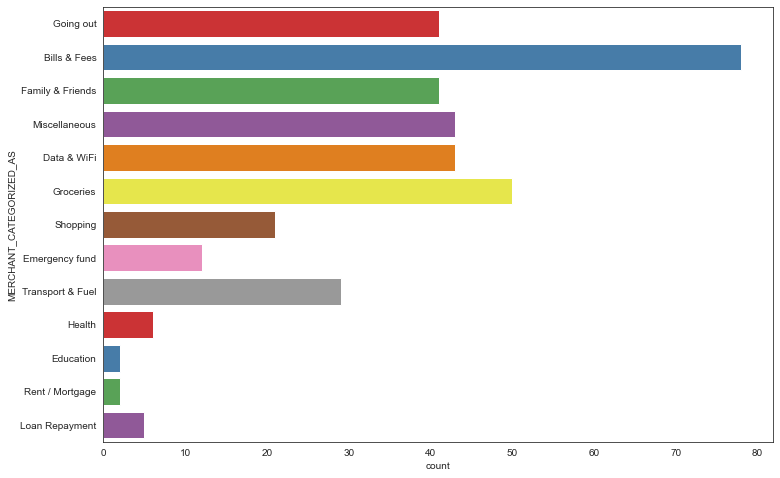

In [21]:
#Target Histogram
sns.set_style("white") 
sns.countplot( y='MERCHANT_CATEGORIZED_AS', data=train_df, palette="Set1");

In [22]:
counts = train_df['MERCHANT_CATEGORIZED_AS'].value_counts()
print(f'Frequencies:\n{counts}')

Frequencies:
Bills & Fees        78
Groceries           50
Miscellaneous       43
Data & WiFi         43
Going out           41
Family & Friends    41
Transport & Fuel    29
Shopping            21
Emergency fund      12
Health               6
Loan Repayment       5
Education            2
Rent / Mortgage      2
Name: MERCHANT_CATEGORIZED_AS, dtype: int64


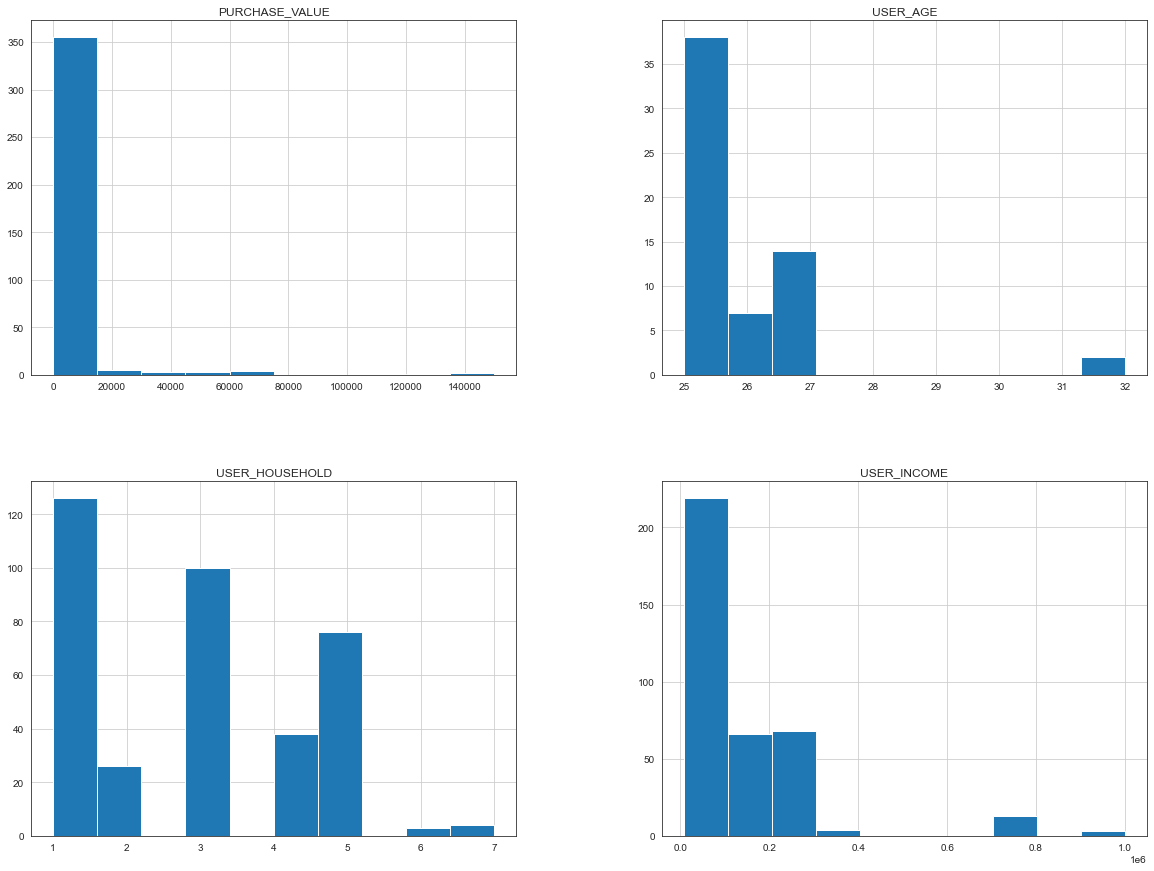

In [23]:
#Numerical Features Histograms (Train)
num_feats = list(train_df.select_dtypes(include=['int64', 'float64', 'int32']).columns)
train_df[num_feats].hist(figsize=(20,15));

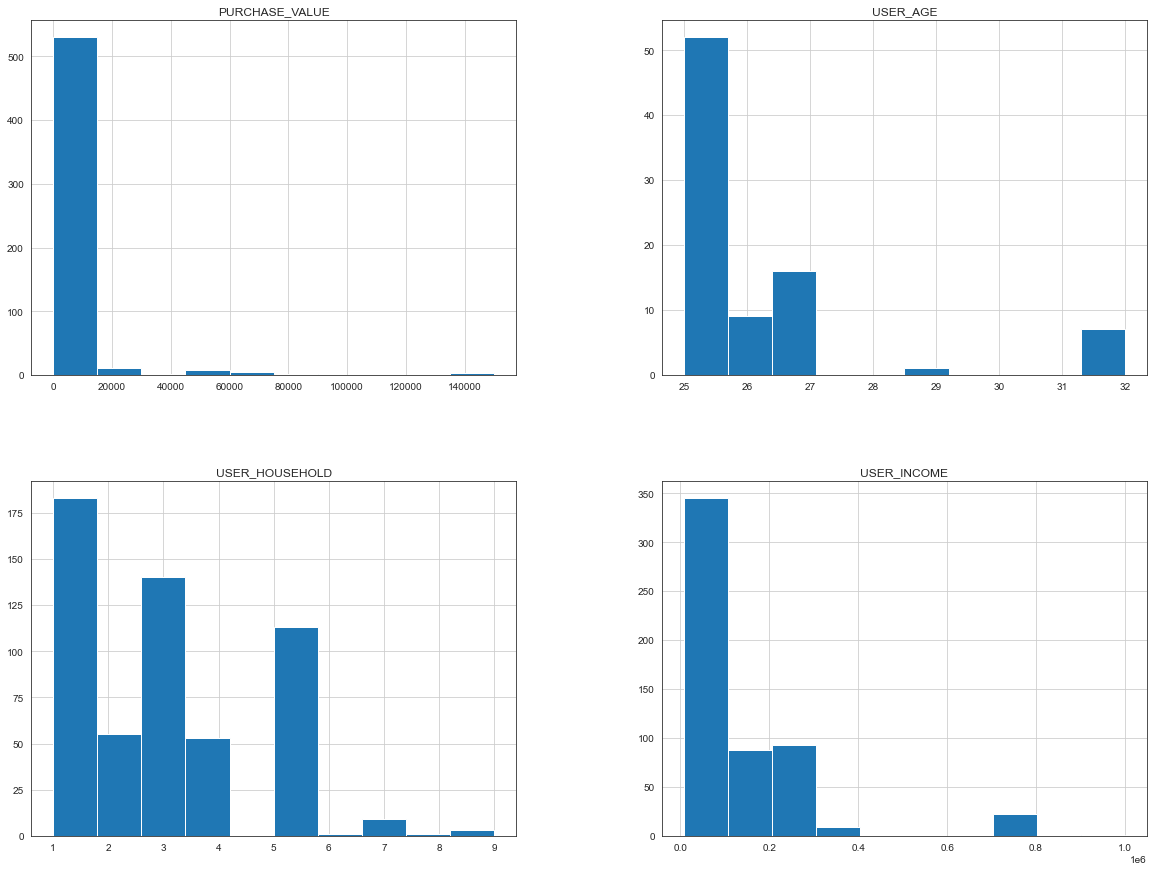

In [24]:
#Numerical Features Histograms (Test)
num_feats = list(test_df.select_dtypes(include=['int64', 'float64', 'int32']).columns)
test_df[num_feats].hist(figsize=(20,15));

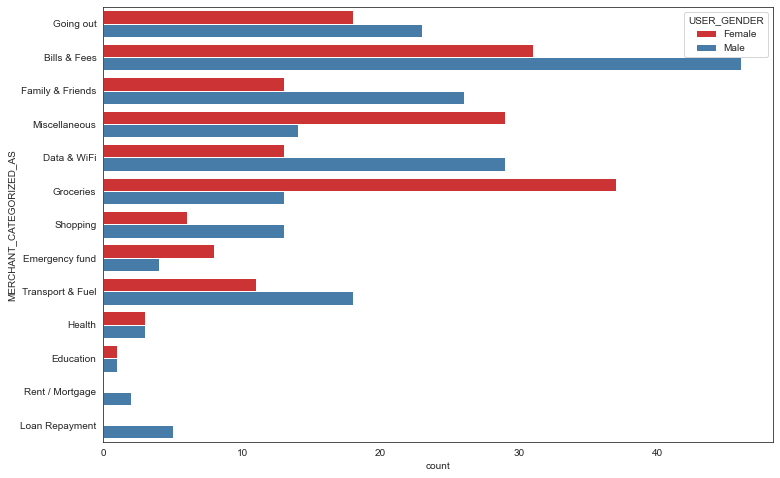

In [25]:
#Target VS USER_GENDER 
sns.countplot( y='MERCHANT_CATEGORIZED_AS', data=train_df, hue="USER_GENDER", palette="Set1");

##### Apperantly, women tend to use the app to buy groceries and miscellaneous much more than men. This is the case for getting an emergency fund as well.

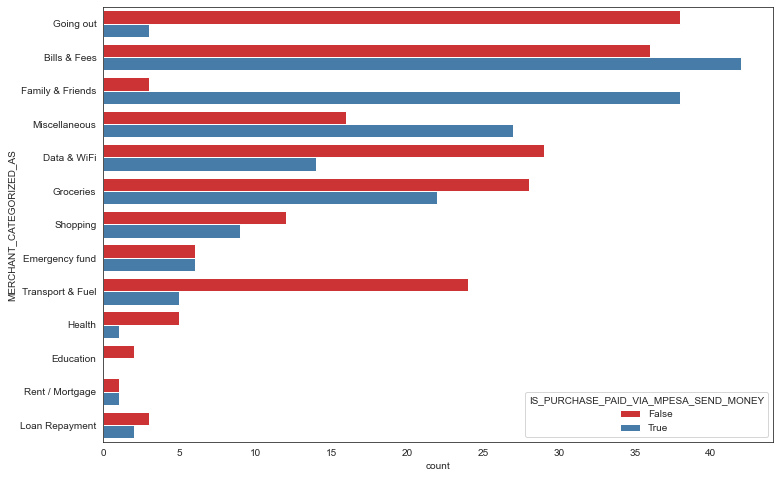

In [26]:
#Target VS IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY
sns.countplot( y='MERCHANT_CATEGORIZED_AS', data=train_df, hue="IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY", palette="Set1");

##### Surprisingly, most of the Data & Wifi merchants are not registered companies while in most countries they are considered as official companies.

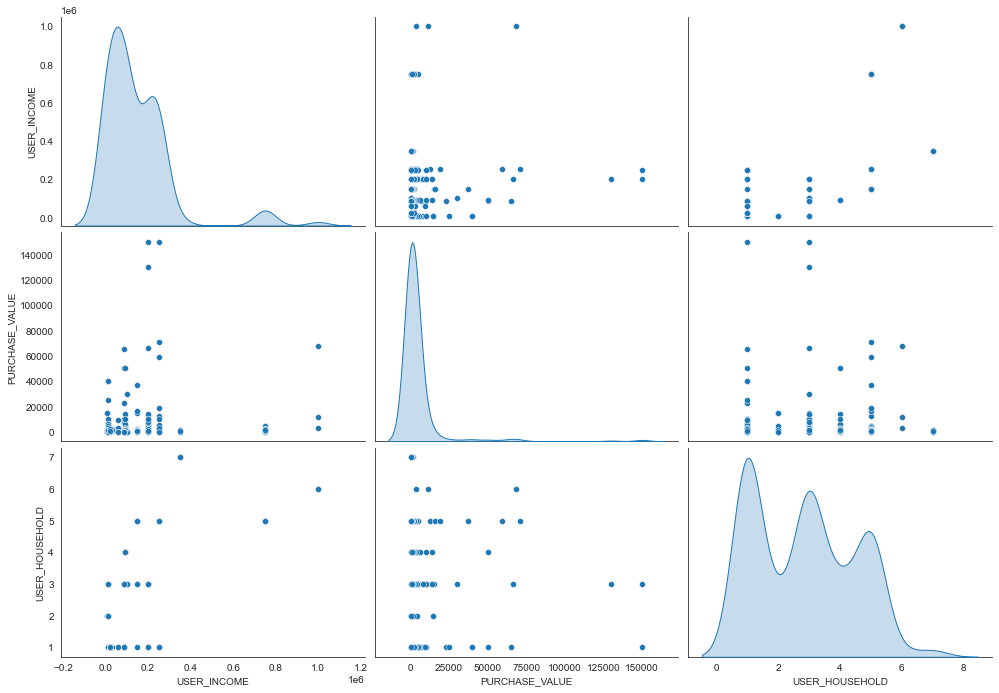

In [27]:
attributes = ["USER_INCOME", "PURCHASE_VALUE","USER_HOUSEHOLD"]
sns.pairplot(train_df.reset_index(drop=True)[attributes], diag_kind="kde")
plt.gcf().set_size_inches(15, 10)

##### There is no obvious relation between the User Income and his purchases values. But we can see a small positive linear relation between the Income and the number of family members.

# Feature Engineering

## Imputing Some of The Missing Values

In [28]:
train_df['USER_AGE'] = train_df['USER_AGE'].fillna(25.0)      
test_df['USER_AGE'] = test_df['USER_AGE'].fillna(25.0)

train_df['USER_GENDER'] = train_df['USER_GENDER'].fillna('Female')     
test_df['USER_GENDER'] = test_df['USER_GENDER'].fillna('Female')

## Add Aggregations

In [29]:
temp = pd.concat([train_df,test_df,extra_df],axis=0)

def Agg_1(Feature):
    for dataset in (train_df,test_df,extra_df):
        for key in ('USER_ID','MERCHANT_NAME','IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY'):
            dataset[f'{Feature}_{key}_Mean'] = dataset[key].map(dict(temp.groupby(key)[Feature].mean()))
            dataset[f'{Feature}_{key}_Quantile10'] = dataset[key].map(dict(temp.groupby(key)[Feature].quantile(0.10)))
            dataset[f'{Feature}_{key}_Quantile25'] = dataset[key].map(dict(temp.groupby(key)[Feature].quantile(0.25)))
            dataset[f'{Feature}_{key}_Quantile75'] = dataset[key].map(dict(temp.groupby(key)[Feature].quantile(0.75)))
            dataset[f'{Feature}_{key}_Quantile90'] = dataset[key].map(dict(temp.groupby(key)[Feature].quantile(0.90)))
            dataset[f'{Feature}_{key}_Std'] = dataset[key].map(dict(temp.groupby(key)[Feature].std()))
            dataset[f'{Feature}_{key}_Min'] = dataset[key].map(dict(temp.groupby(key)[Feature].min()))
            dataset[f'{Feature}_{key}_Max'] = dataset[key].map(dict(temp.groupby(key)[Feature].max()))
            dataset[f'{Feature}_{key}_Sum'] = dataset[key].map(dict(temp.groupby(key)[Feature].sum()))
            dataset[f'{Feature}_{key}_Range'] = dataset[key].map(dict(temp.groupby(key)[Feature].agg(np.ptp)))
            dataset[f'{Feature}_{key}_Kurt'] = dataset[key].map(dict(temp.groupby(key)[Feature].agg(pd.Series.kurt)))
            dataset[f'{Feature}_{key}_Skew'] = dataset[key].map(dict(temp.groupby(key)[Feature].agg(pd.Series.skew)))
  
Agg_1('PURCHASE_VALUE')

In [30]:
# def Agg_2(Feature):
#     for dataset in (train_df,test_df):
#         for key in ('USER_ID','MERCHANT_NAME','IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY'):
#             dataset[f'{Feature}_{key}_Mode'] = dataset[key].map(dict(train_df.groupby(key)[Feature].apply(lambda x: x.value_counts().keys()[0])))
#             dataset[f'{Feature}_{key}_Count'] = dataset[key].map(dict(train_df.groupby(key)[Feature].count()))
#             dataset[f'{Feature}_{key}_NUnique'] = dataset[key].map(dict(train_df.groupby(key)[Feature].nunique()))
  
# Agg_2('MERCHANT_CATEGORIZED_AS')

# #To Avoid leaking the Target
# train_df.drop('MERCHANT_CATEGORIZED_AS_MERCHANT_NAME_Mode',inplace=True,axis=1)
# test_df.drop('MERCHANT_CATEGORIZED_AS_MERCHANT_NAME_Mode',inplace=True,axis=1)

## Imputing The Other Missing Values

In [31]:
df = pd.concat([train_df,test_df])
values = df.mode().loc[0]
train_df = train_df.fillna(values)
test_df = test_df.fillna(values)

## Frequency of Words in Merchants Names

In [32]:
df = pd.concat([train_df,test_df,extra_df])

CouVec = CountVectorizer()
CouVec.fit(df['MERCHANT_NAME'])

train_words = pd.DataFrame(CouVec.transform(train_df['MERCHANT_NAME']).toarray())
test_words = pd.DataFrame(CouVec.transform(test_df['MERCHANT_NAME']).toarray())
extra_words = pd.DataFrame(CouVec.transform(extra_df['MERCHANT_NAME']).toarray())

## Text Features

In [33]:
def tag_part_of_speech(text):
    text_splited = text.split(' ')
    text_splited = [''.join(c for c in s if c not in string.punctuation) for s in text_splited]
    text_splited = [s for s in text_splited if s]
    pos_list = nltk.pos_tag(text_splited)
    noun_count = len([w for w in pos_list if w[1] in ('NN','NNP','NNPS','NNS')])
    adjective_count = len([w for w in pos_list if w[1] in ('JJ','JJR','JJS')])
    verb_count = len([w for w in pos_list if w[1] in ('VB','VBD','VBG','VBN','VBP','VBZ')])
    return[noun_count, adjective_count, verb_count]

for df in ([train_df,test_df]):
  
    df['Merchant_Name_Length'] = df['MERCHANT_NAME'].apply(lambda x : len(x))
    df['Num_Words'] = df['MERCHANT_NAME'].apply(lambda comment: len(comment.split()))
    df['Num_Unique_Words'] = df['MERCHANT_NAME'].apply(lambda comment: len(set(w for w in comment.split())))
    df['Words_VS_Unique'] = df['Num_Unique_Words'] / df['Num_Words']
    df['num_punctuation'] = df['MERCHANT_NAME'].apply(lambda comment: sum(comment.count(w) for w in '\'.,;:'))
    df['nouns'], df['adjectives'], df['verbs'] = zip(*df['MERCHANT_NAME'].apply(lambda comment: tag_part_of_speech(comment)))
    df['nouns_vs_length'] = df['nouns'] / df['Merchant_Name_Length']
    df['adjectives_vs_length'] = df['adjectives'] / df['Merchant_Name_Length']
    df['verbs_vs_length'] = df['verbs'] /df['Merchant_Name_Length']
    df['nouns_vs_words'] = df['nouns'] / df['Num_Words']
    df['adjectives_vs_words'] = df['adjectives'] / df['Num_Words']
    df['verbs_vs_words'] = df['verbs'] / df['Num_Words']
    df["count_words_title"] = df["MERCHANT_NAME"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
    df["mean_word_len"] = df["MERCHANT_NAME"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
    df['punct_percent']= df['num_punctuation']*100/df['Num_Words']

## Topic Modeling (Clustering The Merchants Names Based on Words)

In [34]:
LDA = LatentDirichletAllocation(n_components=15, max_iter=100, random_state=42)
LDA.fit(pd.concat([train_words,test_words,extra_words]))
Topics = [f'Topic_{x}' for x in range(0,15)]
train_df[Topics] = LDA.transform(train_words)
test_df[Topics] = LDA.transform(test_words)

### Show The Clusters

In [35]:
n_top_words = 10
topic_summaries = []

# get topics and topic terms
topic_word = LDA.components_ 
vocab = CouVec.get_feature_names()

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))
    print('Topic {}: {}'.format(i, ' | '.join(topic_words)))

Topic 0: limited | restaurant | on | mbaires | osore | fatuma | investment | and | chandarana | wanjohi
Topic 1: nairobi | java | county | revenue | kra | limited | church | boniface | ngelenzi | kyala
Topic 2: beauty | investments | peter | kenda | city | ltd | salon | rubis | tin | and
Topic 3: limited | carrefour | kenya | cellulant | wines | and | tingg | spirits | paytech | two
Topic 4: parking | kaps | naomi | gathuu | online | pesapal | oaks | corks | ecitizen | mwangi
Topic 5: ltd | hotel | limited | and | the | baraka | rescue | bank | via | kplc
Topic 6: shop | station | bank | via | shell | service | kilifi | and | spanneright | hardware
Topic 7: wanjiru | caroline | pharmacy | ltd | sarit | centre | nyokabi | hub | unit | trust
Topic 8: ltd | kenya | kitchen | liquor | and | limited | zalena | store | oilibya | via
Topic 9: account | shwari | bank | collection | co | operative | equity | paybill | lock | savings
Topic 10: ltd | ipay | butchery | services | pesa | francis | 

## Encoding

In [36]:
lbl_enc = LabelEncoder()

In [37]:
train_df['MERCHANT_CATEGORIZED_AS'] = lbl_enc.fit_transform(train_df['MERCHANT_CATEGORIZED_AS'].values)

for feat in ['MERCHANT_CATEGORIZED_AS_USER_ID_Mode','MERCHANT_CATEGORIZED_AS_IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY_Mode']:
    
    train_df[feat] = train_df[feat].ffill().bfill()
    test_df[feat] = test_df[feat].ffill().bfill()
   
    train_df[feat] = lbl_enc.transform(train_df[feat])
    test_df[feat] = lbl_enc.transform(test_df[feat])

KeyError: 'MERCHANT_CATEGORIZED_AS_USER_ID_Mode'

In [40]:
features = list(train_df.select_dtypes(include=['object']).columns)
full_data = pd.concat([train_df[features], test_df[features]],axis=0)
for col in (features):
    print(col)
    lbl_enc.fit(full_data[col].values)
    train_df[col] = lbl_enc.transform(train_df[col])
    test_df[col] = lbl_enc.transform(test_df[col])

MERCHANT_CATEGORIZED_AT
MERCHANT_NAME
USER_GENDER
USER_ID


## Drop Duplicated and Constant Features

In [41]:
#Duplicated
cols = train_df.columns
dup = []
for feat_1 in cols:
    if (feat_1 in dup):
        continue
    for feat_2 in cols.drop(feat_1):
        if (feat_2 in dup):
            continue
        if (train_df[feat_1].equals(train_df[feat_2])):
            train_df.drop(feat_2,inplace=True,axis=1)
            test_df.drop(feat_2,inplace=True,axis=1)
            dup.append(feat_2)

In [42]:
#Constant
for feat in test_df.columns:
    if ((len(train_df[feat].value_counts().keys()) == 1) | (len(test_df[feat].value_counts().keys()) == 1)):
        train_df.drop(feat,inplace=True,axis=1)
        test_df.drop(feat,inplace=True,axis=1)

# Modeling

In [47]:
cb_params = {'iterations':1300, 'learning_rate': 0.09, 'depth': 6, 'reg_lambda': 17.56889442852513, 'verbose': 0}
cb = CatBoostClassifier(**cb_params, random_state = 42)

rf_params = {'n_estimators': 2600, 'max_depth': 12, 'min_samples_split': 3,'min_samples_leaf': 1, 'max_features': 0.35}
rf = RandomForestClassifier(**rf_params, n_jobs= -1, random_state= 42)

knn_params = {'n_neighbors': 135, 'weights': 'distance', 'algorithm': 'auto', 'leaf_size': 1, 'p': 1, 'n_jobs': -1}
knn = KNeighborsClassifier(**knn_params)

xgb = XGBClassifier(random_state = 42, objective = 'multi:softprob', num_class = 13, learning_rate = 0.05976,  max_depth = 6, 
                    subsample = 0.5, colsample_bytree = 0.5, eval_metric='mlogloss')

In [51]:
print('Validating...')
scores = []


X_split = train_df.drop('MERCHANT_CATEGORIZED_AS',axis=1).values
y_split = train_df['MERCHANT_CATEGORIZED_AS'].values

X = train_df.drop('MERCHANT_CATEGORIZED_AS',axis=1).reset_index(drop=True)


scores = []
for train_index, test_index in StratifiedKFold(n_splits=2,shuffle=True,random_state=42).split(X_split, y_split):

        X_Train, X_Test = X_split[train_index], X_split[test_index]
        y_Train, y_Test = y_split[train_index], y_split[test_index]
        cb.fit(X_Train,y_Train)
        rf.fit(X_Train,y_Train)
        knn.fit(np.log(X_Train.astype(float)+10),y_Train)
        xgb.fit(X_Train,y_Train)
        
        y_pred = 0.35*cb.predict_proba(X_Test) + 0.4*rf.predict_proba(X_Test) + 0.1*xgb.predict_proba(X_Test) + 0.15*knn.predict_proba(np.log(X_Test.astype(float)+10)) 
        scores.append(log_loss(y_Test,y_pred))
        print(scores[-1])

print("\nMean:",np.mean(scores),"\nSTD: ", np.std(scores))

Validating...
1.4819362268797922
1.4350227804581666

Mean: 1.4584795036689795 
STD:  0.023456723210812824


# Make the Submission File 

In [52]:
X = train_df.drop('MERCHANT_CATEGORIZED_AS',axis=1)
y = train_df['MERCHANT_CATEGORIZED_AS']
        
cb.fit(X,y)
rf.fit(X,y)
knn.fit(np.log(X.astype(float)+10),y)
xgb.fit(X,y)

In [82]:
Predictions = 0.6 * (0.4*cb.predict_proba(test_df) + 0.3*rf.predict_proba(test_df) + 0.3*xgb.predict_proba(test_df)) + 0.2 *cb.predict_proba(test_df) + 0.2*xgb.predict_proba(test_df)

In [83]:
submission = pd.DataFrame({"Id": ID})
Predictions = pd.DataFrame(Predictions, index = test_df.index, columns = Target_Values)
submission = pd.concat([submission.reset_index(drop=True),Predictions.reset_index(drop=True)],axis=1)

submission.to_csv('aisquad_cb.csv',index=False)

## LB Score: 1.372343425651699

## Show the Features Importances 

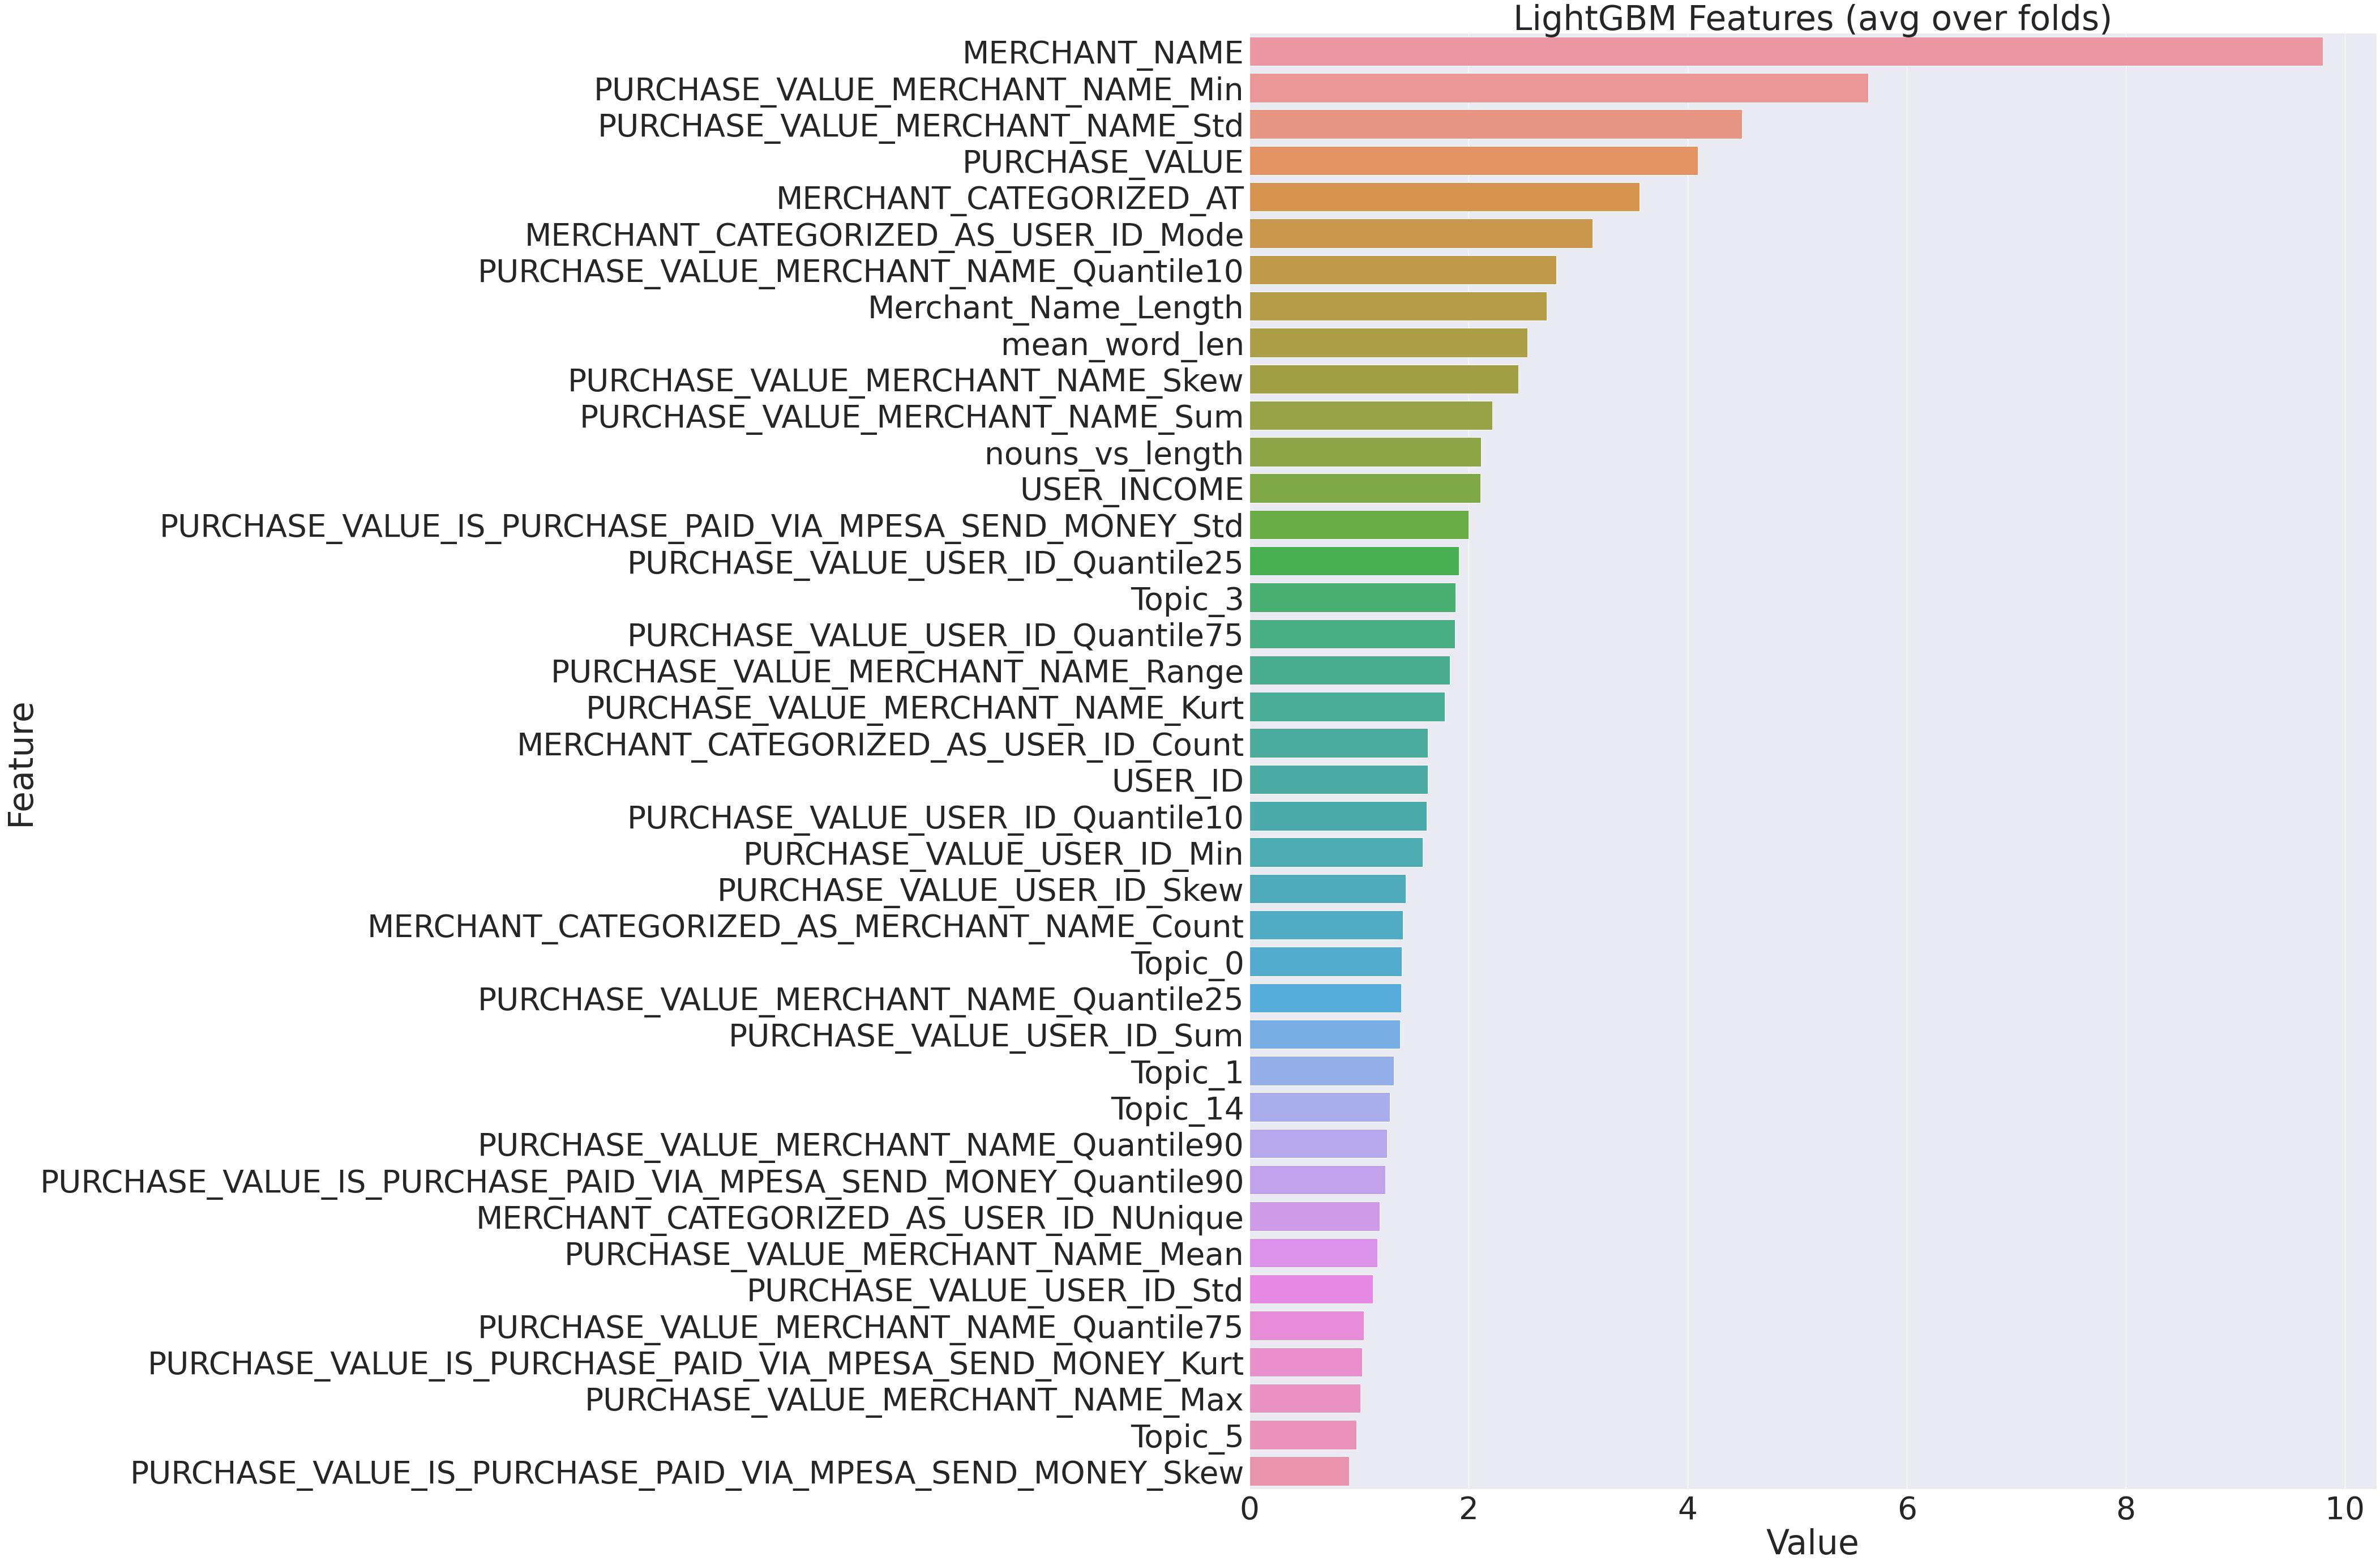

In [176]:
plotImp(cb,train_df.drop('MERCHANT_CATEGORIZED_AS',axis=1))